# Weather Underground Hurricane Data

-----

## Processed Data Research

A notebook for researching the processed Weather Underground data from the ```src/process_data.py``` script.

In [1]:
# Imports
import os
import pickle
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
# Variables
processed_dir = '../data/processed/'

# - Load Data
with open(os.path.join(processed_dir, 'region_data.pkl'), 'rb') as fin:
    region_df = pickle.load(fin)

with open(os.path.join(processed_dir, 'region_yearly_data.pkl'), 'rb') as fin:
    region_yearly_df = pickle.load(fin)

with open(os.path.join(processed_dir, 'storm_track_data.pkl'), 'rb') as fin:
    storm_track_dict = pickle.load(fin)


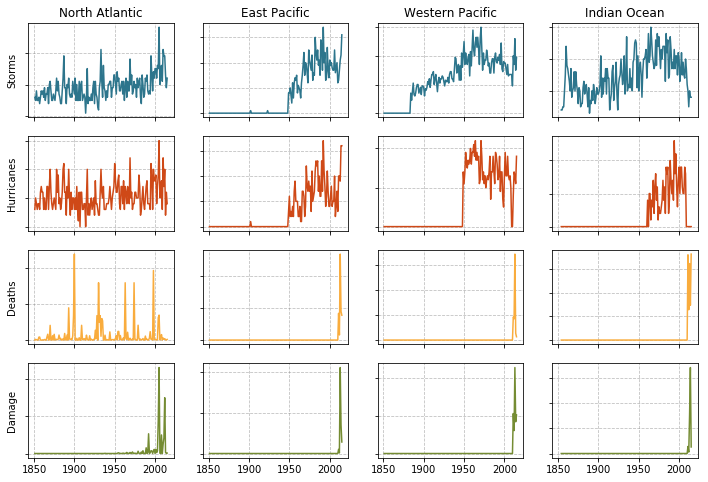

In [3]:
# - Plot data by region
regions = ['North Atlantic', 'East Pacific', 'Western Pacific', 'Indian Ocean']

stats = ['Storms', 'Hurricanes', 'Deaths', 'Damage']
colors = ['#2d758c', '#cf4917', '#f9ac3d', '#758c33']

fig, axs = plt.subplots(nrows=4, ncols=4, sharex=True, figsize=(12, 8))

i_col = 0
for region in regions:
    t_reg_df = region_df.loc[:, region]
    
    i_row = 0
    for statistic in stats:
        ax = axs[i_row][i_col]
        clr = colors[i_row]
        t_reg_df.loc[:, statistic].plot(ax=ax, color=clr)
        ax.grid(linestyle='--', color='grey', alpha=0.5)
        
        ax.set_yticklabels([])
        if i_col == 0:
            ax.set_ylabel(statistic)
    
        if i_row == 0:
            ax.set_title(region)
    
        i_row += 1
    
    i_col += 1

fig.savefig('../media/region_data_by_region_stat.png')
plt.show();

In [4]:
# - Get common starting date
plt_start = region_df.first_valid_index()
for region in set(region_df.columns.get_level_values('Region')):
    t_df = region_df.loc[:, pd.IndexSlice[region, 'Hurricanes']]
    t_df[t_df == 0.] = np.nan
    t_start_dt = t_df.first_valid_index()
    
    if t_start_dt > plt_start:
        plt_start = t_start_dt

print("Common starting date: {}".format(plt_start))

Common starting date: 1961


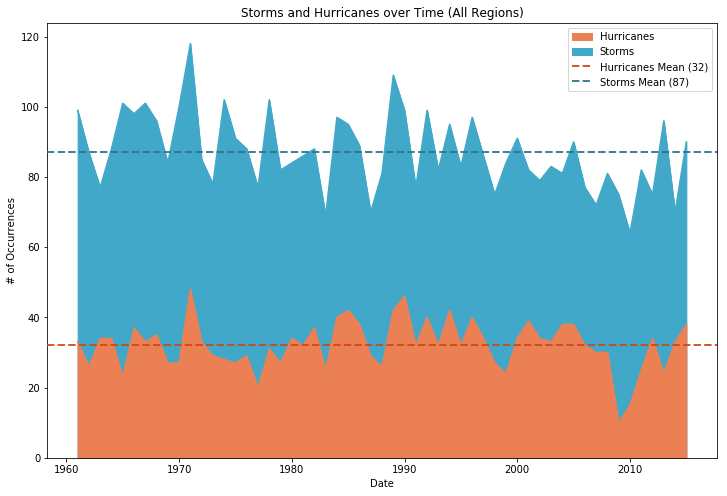

In [5]:
# - Total occurences over time
agg_data = region_df.groupby(level='Statistic', axis=1).sum().loc[plt_start:]
pct_hurricanes = agg_data.loc[:, 'Hurricanes'] / agg_data.loc[:, 'Storms']

avg_counts = agg_data.loc[:, ['Hurricanes', 'Storms']].mean().values
avg_pct = pct_hurricanes.mean()

# - Plot
plot_percentages = False

fig, ax = plt.subplots(figsize=(12, 8))

agg_data.loc[:, 'Storms'].plot.area(ax=ax, alpha=1, color='#41a8c9', zorder=1)
agg_data.loc[:, 'Hurricanes'].plot.area(ax=ax, alpha=1, color='#ec8055', zorder=2)

ax.axhline(avg_counts[1], label='Storms Mean ({:.0f})'.format(avg_counts[1]),
           color='#2d758c', alpha=0.9, linestyle='--', linewidth=2, zorder=3)
ax.axhline(avg_counts[0], label='Hurricanes Mean ({:.0f})'.format(avg_counts[0]),
           color='#cf4917', alpha=0.9, linestyle='--', linewidth=2, zorder=3)

ax.set_title('Storms and Hurricanes over Time (All Regions)')
ax.set_ylabel('# of Occurrences');
ax.set_xlabel('Date')

lines, labels = ax.get_legend_handles_labels()
if plot_percentages:
    ax2 = (pct_hurricanes * 100.).plot(ax=ax, secondary_y=True, zorder=4, linestyle='-',
                                       color='#d0b285', linewidth=2.5, 
                                       label='Percent Hurricanes')
    ax2.axhline(avg_pct*100., label='Percent Mean ({:.1f}%)'.format(100.*avg_pct),
                color='#a2783c', alpha=0.9, linestyle='--', linewidth=2, zorder=5)

    ax2.set_ylim((0, 100))
    ax2.set_ylabel('Percent (%)')

    
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax.legend(lines[::-1]+lines_2, labels[::-1]+labels_2, loc='upper right')
else:
    ax.legend(lines[::-1], labels[::-1], loc='upper right')
    

fig.savefig('../media/storms_hurricanes_all_regions.png')
plt.show();

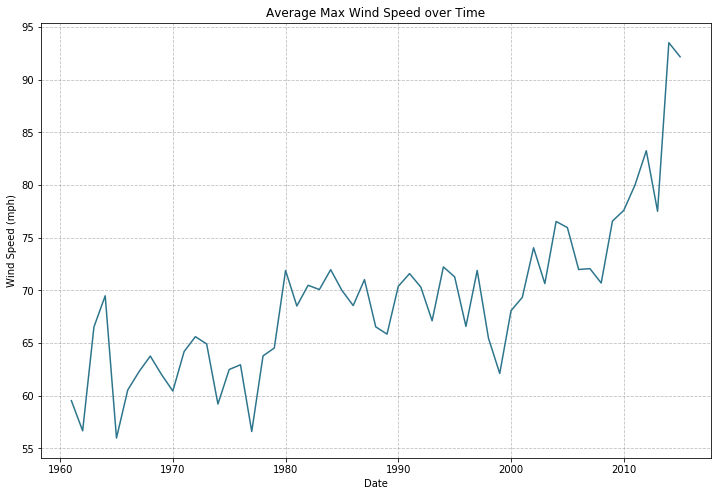

In [6]:
# - Get avg max winds data
start_dates = region_yearly_df.loc[:, ['Start Date']].set_index('Start Date').index
cut_region_yearly = region_yearly_df.loc[start_dates.year >= plt_start, :]
cut_start_dates = cut_region_yearly.loc[:, ['Start Date']].set_index('Start Date').index

avg_max_wind_speed = cut_region_yearly.loc[:, 'Max Winds'].groupby(cut_start_dates.year).mean()

# - Plot
fig, ax = plt.subplots(figsize=(12, 8))

avg_max_wind_speed.plot(ax=ax, color='#2d758c')
ax.grid(linestyle='--', color='grey', alpha=0.5)

ax.set_title('Average Max Wind Speed over Time')
ax.set_ylabel('Wind Speed (mph)')
ax.set_xlabel('Date')

fig.savefig('../media/avg_max_wind_speed_by_year.png')
plt.show();

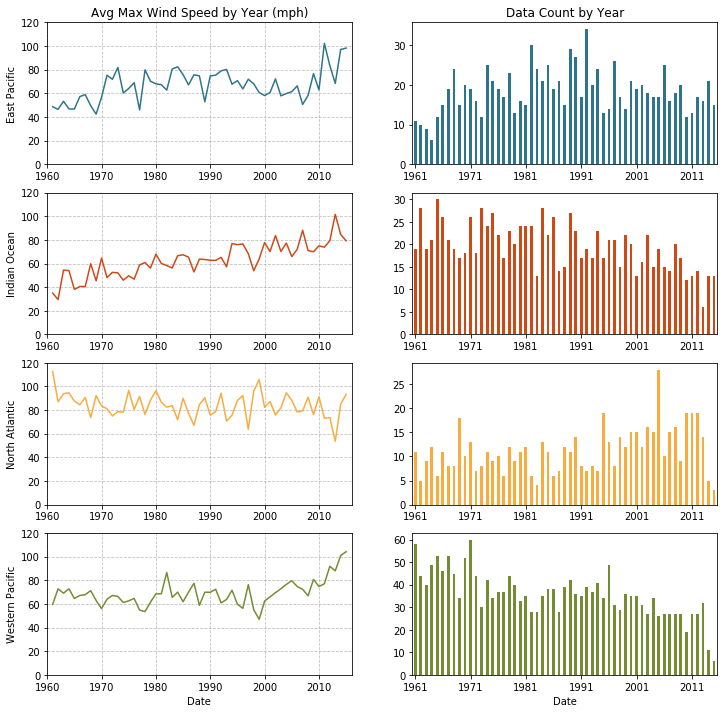

In [7]:
# - Avg Max Wind Speed by Region
reg_avgmaxwind = cut_region_yearly.groupby(['Region', cut_start_dates.year], axis=0) \
                                  .mean().loc[:, 'Max Winds'].unstack('Region')
reg_counts = cut_region_yearly.groupby(['Region', cut_start_dates.year], axis=0).count() \
                              .loc[:, 'Max Winds'].unstack('Region')

# - Plot
fig, axs = plt.subplots(nrows=4, ncols=2, sharex=False, figsize=(12, 12))

colors = ['#2d758c', '#cf4917', '#f9ac3d', '#758c33']
i = 0
for reg in reg_avgmaxwind.columns:
    ax = axs[i][0]
    reg_avgmaxwind.loc[:, reg].plot(ax=ax, label=reg, color=colors[i])
    ax.set_ylim((0, 120))
    ax.set_xlim((1960, 2016))
    ax.grid(linestyle='--', color='grey', alpha=0.5)
    ax.set_ylabel(reg)
    ax.set_xlabel('')
        
    ax = axs[i][1]
    reg_counts.loc[:, reg].plot(ax=ax, kind='bar', label='Count', color=colors[i])
    ax.xaxis.set_major_locator(plt.MultipleLocator(10))
    ax.xaxis.set_ticklabels([plt_start] + list(range(plt_start, 2015, 10)), rotation=0)
    ax.set_xlabel('')
    
    i += 1

axs[0][0].set_title('Avg Max Wind Speed by Year (mph)')
axs[0][1].set_title('Data Count by Year')
axs[-1][0].set_xlabel('Date')
axs[-1][1].set_xlabel('Date')

fig.savefig('../media/avg_max_winds_by_region.png')
plt.show();